# Sliding Window in Pandas

This notebook contains the code to run the exercises in this [Towards Data Science blogpost]().

The text in this notebook is minimal, read the blog for the full narrative and explanation.

In [1]:
# OBJECTIVE
# Using 1 hour of Rideshare (Uber/Lyft) data from NYC we want to
# -- Identify zones with peaks in demand
# We'll start by doing a very rough pass over the whole dataset (1 hour) to identify high-demand zones
# But ideally we want more granularity

# We then move on to do 15-minute rolling windows.
# Better, but still not great.

# Eventually we want to do this in 5-minute sliding windows with 4-minute overlap
# i.e. we want a signal every minute whether the zone is experiencing peak demand or not
# peak demand = n_requests above a certain threshold (say, 50 requests per 5-min window)

In [2]:
import pandas as pd
import numpy as np
import pathway as pw

    Finished dev [optimized + debuginfo] target(s) in 1.28s


In [3]:
df = pd.read_parquet("fhvhv_tripdata_2022-01_100Ksubset.parquet")

In [4]:
# df = pd.read_parquet("fhvhv_tripdata_2022-01.parquet").head(10_000)

In [5]:
df.tail()

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,...,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
99995,HV0003,B03404,B03404,2022-01-01 02:36:27,2022-01-01 02:37:20,2022-01-01 02:38:58,2022-01-01 02:49:11,158,48,2.330,...,4.26,2.75,0.0,0.00,27.19,N,N,,N,N
99996,HV0003,B03404,B03404,2022-01-01 02:49:26,2022-01-01 02:50:09,2022-01-01 02:51:20,2022-01-01 03:07:54,48,236,4.240,...,2.15,2.75,0.0,5.96,20.06,N,N,,N,N
99997,HV0005,B03406,None,2022-01-01 02:07:02,NaT,2022-01-01 02:13:17,2022-01-01 02:23:17,80,157,3.416,...,3.41,0.00,0.0,0.00,23.04,N,N,N,N,N
99998,HV0005,B03406,None,2022-01-01 02:29:19,NaT,2022-01-01 02:34:19,2022-01-01 02:46:00,160,134,5.211,...,1.41,0.00,0.0,0.00,11.65,N,N,N,N,N
99999,HV0003,B03404,B03404,2022-01-01 02:23:13,2022-01-01 02:28:23,2022-01-01 02:30:24,2022-01-01 02:43:26,40,231,3.600,...,2.51,2.75,0.0,0.00,14.16,N,N,,N,N


### 1. Identify High-Demand Pickup Zones over 15-minute period (CRUDE METHOD)

In [6]:
# each row is a pickup (and a dropoff)
# so we want the number of rows in a PULocationID during a particular period of time (1 hour)

In [7]:
df.columns

Index(['hvfhs_license_num', 'dispatching_base_num', 'originating_base_num',
       'request_datetime', 'on_scene_datetime', 'pickup_datetime',
       'dropoff_datetime', 'PULocationID', 'DOLocationID', 'trip_miles',
       'trip_time', 'base_passenger_fare', 'tolls', 'bcf', 'sales_tax',
       'congestion_surcharge', 'airport_fee', 'tips', 'driver_pay',
       'shared_request_flag', 'shared_match_flag', 'access_a_ride_flag',
       'wav_request_flag', 'wav_match_flag'],
      dtype='object')

In [8]:
df.tail(2)

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,...,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
99998,HV0005,B03406,None,2022-01-01 02:29:19,NaT,2022-01-01 02:34:19,2022-01-01 02:46:00,160,134,5.211,...,1.41,0.00,0.0,0.0,11.65,N,N,N,N,N
99999,HV0003,B03404,B03404,2022-01-01 02:23:13,2022-01-01 02:28:23,2022-01-01 02:30:24,2022-01-01 02:43:26,40,231,3.600,...,2.51,2.75,0.0,0.0,14.16,N,N,,N,N


In [9]:
len(df)

100000

In [10]:
## IMPORTANT / USEFUL DATA CLEANING
# timestamps are not sorted correctly >> sort
# dataset includes some trips that were requested before midnight on the year before >> time-mask

In [11]:
# NOTE FOR LATER: 
# rows are not in correct timestamp order
# could set PU_datetime as index and sort
# or use this as realistic streaming example? How to deal with messy incoming data / clocks?

In [12]:
time_mask = (df['request_datetime'].dt.month == 1) & \
            (df['request_datetime'].dt.day == 1) & \
            (df['request_datetime'].dt.hour == 0) #& \
#            (df['request_datetime'].dt.minute >= 0) & \
#            (df['request_datetime'].dt.minute < 15)

In [13]:
df = df[time_mask].sort_values(by=['request_datetime'])
len(df)

41208

In [14]:
df.tail()

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,...,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
68435,HV0005,B03406,None,2022-01-01 00:59:59,NaT,2022-01-01 01:04:41,2022-01-01 01:12:44,89,181,2.852,...,1.41,0.00,0.0,3.57,11.55,N,N,N,N,N
72541,HV0005,B03406,None,2022-01-01 00:59:59,NaT,2022-01-01 01:06:02,2022-01-01 01:11:34,129,82,0.695,...,0.77,0.00,0.0,0.00,10.61,N,N,N,N,N
72421,HV0003,B03404,B03404,2022-01-01 00:59:59,2022-01-01 01:10:20,2022-01-01 01:12:20,2022-01-01 01:15:08,162,170,0.020,...,1.79,2.75,0.0,0.00,11.78,N,N,,N,N
75690,HV0003,B03404,B03404,2022-01-01 00:59:59,2022-01-01 01:03:49,2022-01-01 01:04:23,2022-01-01 01:06:59,7,7,0.590,...,0.57,0.00,0.0,0.00,6.35,N,N,,N,N
40899,HV0003,B03404,B03404,2022-01-01 00:59:59,2022-01-01 01:07:26,2022-01-01 01:09:26,2022-01-01 01:53:20,39,265,30.580,...,0.00,0.00,0.0,0.00,59.21,N,N,,N,N


In [15]:
# once we have the time_mask we can perform a simple groupby with .count()
requests = df[['PULocationID','hvfhs_license_num']].groupby(['PULocationID']).count()

In [16]:
# number of requests per LocationID within this 1-hour window
requests = requests.rename(columns={'hvfhs_license_num':'n_requests'})
requests.head()

,n_requests
PULocationID,
3,62
4,193
5,7
6,9
7,419


In [17]:
requests.sort_values(by='n_requests', ascending=False, inplace=True)
requests.head(20)

,n_requests
PULocationID,
79,861
148,771
48,669
255,632
37,584
61,581
231,571
256,553
68,529


In [18]:
len(requests[(requests.n_requests > 500)])

11

In [19]:
# Sweet. We see that we have 11 PU zones above our threshold (500 requests per hour) in this window.

In [21]:
# this works for a single window (1 hour)
# we could run this code in batch once an hour
# but is not very scalable/flexible
# let's try using windows instead

## 2. Tumbling Windows

In [20]:
# let's make this a little more fine-grained and actionable
# let's do a sliding window over the dataset
# and let's reduce the size of our windows 
# we'll work with 5-min rolling windows
# with a 4-minute overlap (i.e. sliding)
# so we get a signal every minute

In [21]:
# to use pandas rolling() method we need the index to be set to a datetime column
# let's look at the number of requests >> so the request_datetime column

In [22]:
# sort by request_datetime
# and set request_datetime as our index
requests = df[['request_datetime', 'on_scene_datetime', 'pickup_datetime', 'dropoff_datetime', 'PULocationID', 'DOLocationID']][df.request_datetime.dt.year==2022].sort_values(by=['request_datetime']).set_index("request_datetime")

In [23]:
requests.head()

,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID
request_datetime,,,,,
2022-01-01 00:00:00,2022-01-01 00:01:07,2022-01-01 00:03:07,2022-01-01 00:28:09,162,79
2022-01-01 00:00:00,NaT,2022-01-01 00:03:59,2022-01-01 00:32:33,231,197
2022-01-01 00:00:00,2022-01-01 00:06:43,2022-01-01 00:07:01,2022-01-01 00:18:45,236,236
2022-01-01 00:00:01,NaT,2022-01-01 00:06:15,2022-01-01 00:32:21,132,265
2022-01-01 00:00:01,NaT,2022-01-01 00:05:00,2022-01-01 00:26:36,220,246


In [26]:
len(requests)

41208

In [27]:
# There are two options:
# 1. assume you're running batch every 15 minutes and just run a simple groupby
# --- i.e. cut your dataset into 15-minute batches FIRST then calculate # of requests per PULocation
# --- basically what we did in Section (1) above
# 2. use rolling/sliding windows

In [28]:
# we want our output to look like:
# rows that are 15-min brackets AND
# a column for each PULocationID 
# we need a pivot

In [25]:
# let's expand our df to have a unique column for each PULocationID
res = pd.pivot_table(
    requests, 
    values='pickup_datetime', 
    index=requests.index,
    columns=['PULocationID'], 
    aggfunc='count'
)

In [26]:
res.head()

PULocationID,3,4,5,6,7,9,10,11,12,13,...,255,256,257,258,259,260,261,262,263,265
request_datetime,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-01 00:00:01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-01 00:00:03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
2022-01-01 00:00:04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-01 00:00:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
len(res)

3597

In [28]:
# now let's resample to group this data into 15-min windows
res.resample('15min').sum()

PULocationID,3,4,5,6,7,9,10,11,12,13,...,255,256,257,258,259,260,261,262,263,265
request_datetime,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,14.0,26.0,2.0,5.0,64.0,4.0,28.0,12.0,2.0,19.0,...,133.0,123.0,12.0,28.0,19.0,39.0,12.0,24.0,55.0,0.0
2022-01-01 00:15:00,14.0,49.0,1.0,1.0,111.0,5.0,25.0,14.0,2.0,28.0,...,179.0,146.0,21.0,53.0,23.0,46.0,24.0,44.0,71.0,1.0
2022-01-01 00:30:00,15.0,60.0,2.0,2.0,126.0,8.0,34.0,8.0,1.0,37.0,...,166.0,143.0,25.0,43.0,32.0,41.0,39.0,39.0,74.0,0.0
2022-01-01 00:45:00,19.0,58.0,2.0,1.0,118.0,7.0,28.0,11.0,1.0,34.0,...,154.0,141.0,12.0,43.0,31.0,55.0,34.0,41.0,98.0,0.0


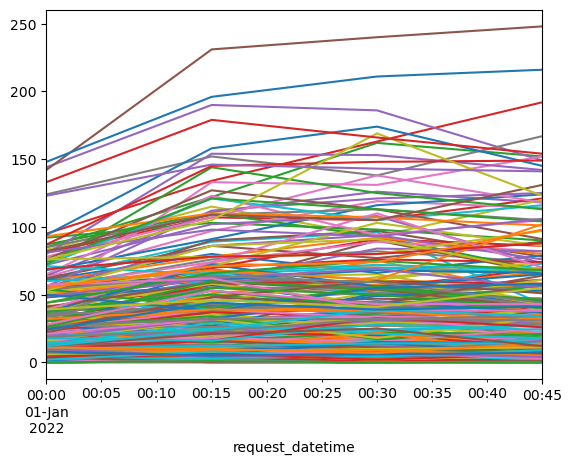

In [29]:
res.resample('15min').sum().plot(legend=False);

In [34]:
# Nice, we have our table with number of requests per pickup zone for each 15-min window
# of course, we're missing out on lots of granularity here
# we need to wait for each 15-min window to finish before we can aggregate the data
# what if the spike happens in the 15-minute window between minute 1 and minute 16 (rather than minute 0 and minute 15)? 
# we will have missed the spike by a minute and will need to wait 14 minutes before receiving the signal >> too late

## 3. Sliding Windows

In [ ]:
# Let's build something more useful.
# We want a signal every minute -- and to reduce the time window to 5 minutes instead of 15.
# This means we need 5-minute sliding windows with 4-minute overlap.

In [35]:
# so what we really want is 56 rows
# row 1: min. 0-5
# row 2: min. 1-6
# row 3: min. 2-7
# ...
# row 55: min. 54-59
# row 56: min. 55-00

In [36]:
# can we use step to get our 15-min windows every minute?
res.rolling('15min', step=1).count()

NotImplementedError: step is not supported with frequency windows

In [37]:
# NO - step is not supported with frequency windows

In [30]:
# let's resample to every minute first
res_1m = res.resample('1min').sum()
res_1m.head(3)

PULocationID,3,4,5,6,7,9,10,11,12,13,...,255,256,257,258,259,260,261,262,263,265
request_datetime,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,1.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,3.0,0.0
2022-01-01 00:01:00,2.0,1.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,...,2.0,8.0,1.0,1.0,2.0,2.0,0.0,3.0,0.0,0.0
2022-01-01 00:02:00,1.0,1.0,0.0,1.0,1.0,0.0,2.0,1.0,0.0,0.0,...,4.0,5.0,0.0,1.0,1.0,2.0,0.0,4.0,1.0,0.0


In [62]:
res_1m.tail()

PULocationID,3,4,5,6,7,9,10,11,12,13,...,255,256,257,258,259,260,261,262,263,265
request_datetime,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:55:00,3.0,2.0,0.0,0.0,10.0,0.0,1.0,0.0,0.0,3.0,...,7.0,4.0,2.0,5.0,3.0,3.0,1.0,1.0,2.0,0.0
2022-01-01 00:56:00,1.0,7.0,0.0,0.0,12.0,1.0,1.0,0.0,1.0,3.0,...,9.0,4.0,0.0,3.0,0.0,7.0,1.0,2.0,4.0,0.0
2022-01-01 00:57:00,1.0,7.0,0.0,0.0,7.0,1.0,2.0,0.0,0.0,4.0,...,7.0,8.0,2.0,1.0,3.0,2.0,1.0,4.0,7.0,0.0
2022-01-01 00:58:00,2.0,4.0,0.0,0.0,8.0,0.0,0.0,2.0,0.0,1.0,...,10.0,7.0,1.0,4.0,2.0,8.0,6.0,1.0,9.0,0.0
2022-01-01 00:59:00,0.0,3.0,0.0,0.0,4.0,1.0,1.0,0.0,0.0,1.0,...,13.0,16.0,2.0,1.0,3.0,3.0,1.0,2.0,9.0,0.0


In [31]:
# now every row is 1 minute so we should be able to use rolling() and sum()
windows = res_1m.rolling(5).sum()
windows.head()

PULocationID,3,4,5,6,7,9,10,11,12,13,...,255,256,257,258,259,260,261,262,263,265
request_datetime,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-01 00:01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-01 00:02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-01 00:03:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-01 00:04:00,4.0,7.0,0.0,3.0,13.0,0.0,8.0,4.0,1.0,1.0,...,20.0,29.0,3.0,9.0,5.0,12.0,2.0,11.0,8.0,0.0


In [42]:
# OK, so by default pandas puts the output on the right-edge of the window
# so I'm seeing the sum for period 0 (0-4) in column #4
# I can set kwarg center=True to have the output in the middle of the window
# this is technically correct since we will only get the first signal at the end of minute 4, when the first window has been completed.

In [64]:
# we can drop the first 4 columns
windows_res = windows.iloc[4:]
windows_res.head()

PULocationID,3,4,5,6,7,9,10,11,12,13,...,255,256,257,258,259,260,261,262,263,265
request_datetime,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:04:00,4.0,7.0,0.0,3.0,13.0,0.0,8.0,4.0,1.0,1.0,...,20.0,29.0,3.0,9.0,5.0,12.0,2.0,11.0,8.0,0.0
2022-01-01 00:05:00,4.0,7.0,0.0,4.0,17.0,0.0,8.0,3.0,1.0,4.0,...,31.0,38.0,4.0,9.0,5.0,15.0,1.0,12.0,7.0,0.0
2022-01-01 00:06:00,4.0,12.0,0.0,4.0,20.0,0.0,6.0,2.0,2.0,4.0,...,34.0,37.0,4.0,11.0,6.0,13.0,1.0,11.0,10.0,0.0
2022-01-01 00:07:00,3.0,11.0,0.0,3.0,22.0,0.0,6.0,3.0,2.0,6.0,...,40.0,40.0,4.0,11.0,7.0,14.0,4.0,7.0,12.0,0.0
2022-01-01 00:08:00,5.0,9.0,0.0,3.0,21.0,1.0,6.0,3.0,2.0,6.0,...,43.0,38.0,4.0,11.0,9.0,15.0,6.0,7.0,13.0,0.0


In [32]:
# for legibility, you might want to move the values to the left edge
# this is more easily readable
# but be careful not to make the mistake of thinking that you will actually have data for window 1 at minute 1 (!)

# use the FixedForwardWindowIndexer object to place the window output on the left edge
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=5)
windows_f = res_1m.rolling(window=indexer).sum()
windows_f.head()

PULocationID,3,4,5,6,7,9,10,11,12,13,...,255,256,257,258,259,260,261,262,263,265
request_datetime,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,4.0,7.0,0.0,3.0,13.0,0.0,8.0,4.0,1.0,1.0,...,20.0,29.0,3.0,9.0,5.0,12.0,2.0,11.0,8.0,0.0
2022-01-01 00:01:00,4.0,7.0,0.0,4.0,17.0,0.0,8.0,3.0,1.0,4.0,...,31.0,38.0,4.0,9.0,5.0,15.0,1.0,12.0,7.0,0.0
2022-01-01 00:02:00,4.0,12.0,0.0,4.0,20.0,0.0,6.0,2.0,2.0,4.0,...,34.0,37.0,4.0,11.0,6.0,13.0,1.0,11.0,10.0,0.0
2022-01-01 00:03:00,3.0,11.0,0.0,3.0,22.0,0.0,6.0,3.0,2.0,6.0,...,40.0,40.0,4.0,11.0,7.0,14.0,4.0,7.0,12.0,0.0
2022-01-01 00:04:00,5.0,9.0,0.0,3.0,21.0,1.0,6.0,3.0,2.0,6.0,...,43.0,38.0,4.0,11.0,9.0,15.0,6.0,7.0,13.0,0.0


In [33]:
# curious what the end of the df looks like 

In [34]:
windows_f.tail(8)

PULocationID,3,4,5,6,7,9,10,11,12,13,...,255,256,257,258,259,260,261,262,263,265
request_datetime,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:52:00,10.0,18.0,0.0,0.0,52.0,1.0,9.0,0.0,1.0,16.0,...,49.0,43.0,3.0,14.0,12.0,23.0,5.0,16.0,29.0,0.0
2022-01-01 00:53:00,8.0,21.0,0.0,0.0,49.0,2.0,11.0,0.0,1.0,18.0,...,43.0,32.0,5.0,14.0,10.0,24.0,5.0,14.0,29.0,0.0
2022-01-01 00:54:00,7.0,21.0,0.0,0.0,45.0,2.0,6.0,2.0,1.0,13.0,...,43.0,29.0,5.0,16.0,12.0,24.0,11.0,12.0,30.0,0.0
2022-01-01 00:55:00,7.0,23.0,0.0,0.0,41.0,3.0,5.0,2.0,1.0,12.0,...,46.0,39.0,7.0,14.0,11.0,23.0,10.0,10.0,31.0,0.0
2022-01-01 00:56:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-01 00:57:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-01 00:58:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-01 00:59:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
# perfect, we can drop the last 4 columns
windows_f_res = windows.iloc[:56]
windows_f_res.tail()

PULocationID,3,4,5,6,7,9,10,11,12,13,...,255,256,257,258,259,260,261,262,263,265
request_datetime,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:51:00,4.0,15.0,2.0,1.0,36.0,1.0,14.0,7.0,0.0,10.0,...,59.0,51.0,3.0,15.0,7.0,14.0,16.0,10.0,33.0,0.0
2022-01-01 00:52:00,6.0,19.0,1.0,1.0,37.0,1.0,11.0,7.0,0.0,10.0,...,59.0,59.0,2.0,9.0,9.0,12.0,12.0,14.0,33.0,0.0
2022-01-01 00:53:00,7.0,19.0,1.0,1.0,43.0,1.0,13.0,2.0,0.0,15.0,...,56.0,60.0,3.0,8.0,8.0,17.0,11.0,15.0,36.0,0.0
2022-01-01 00:54:00,6.0,18.0,1.0,1.0,43.0,1.0,13.0,2.0,0.0,16.0,...,59.0,55.0,2.0,10.0,12.0,18.0,8.0,19.0,39.0,0.0
2022-01-01 00:55:00,9.0,17.0,0.0,1.0,47.0,0.0,12.0,1.0,0.0,14.0,...,51.0,49.0,3.0,13.0,14.0,17.0,6.0,18.0,33.0,0.0


In [49]:
# let's verify

In [65]:
def verify(col, row):
    row_end = row + 5
    return res_1m[col][row:row_end].sum() == windows_res[col][row]

In [66]:
verify(10,6)

True

### Visualize Results

In [36]:
# let's visualize our results
# we'll work with `windows` to clearly reflect the fact that we don't have any data the first 4 minutes.

In [37]:
import matplotlib.pyplot as plt

In [38]:
windows.head()

PULocationID,3,4,5,6,7,9,10,11,12,13,...,255,256,257,258,259,260,261,262,263,265
request_datetime,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-01 00:01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-01 00:02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-01 00:03:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-01 00:04:00,4.0,7.0,0.0,3.0,13.0,0.0,8.0,4.0,1.0,1.0,...,20.0,29.0,3.0,9.0,5.0,12.0,2.0,11.0,8.0,0.0


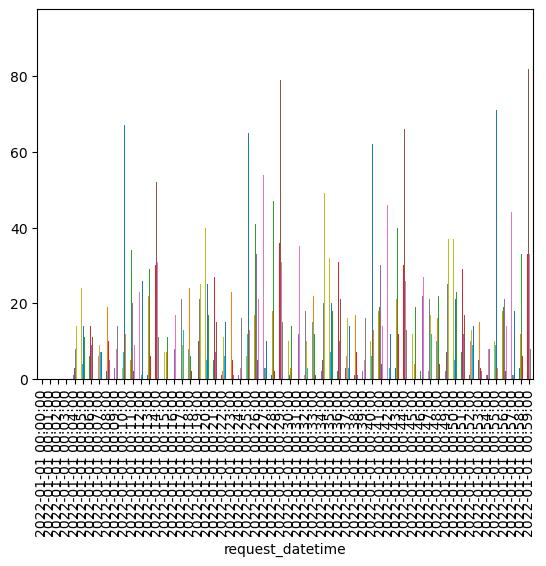

In [39]:
windows.plot(kind='bar', legend=False);

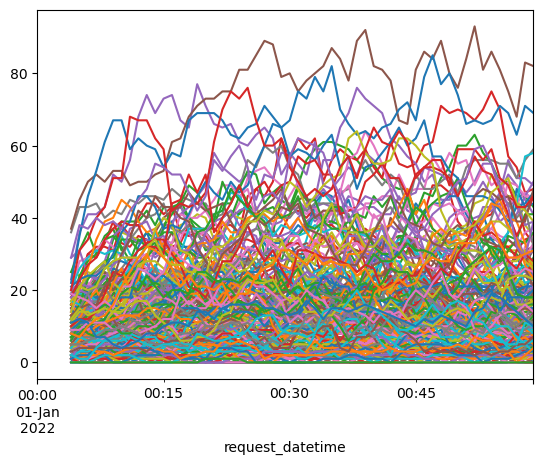

In [40]:
windows.plot(legend=False);

In [49]:
# these are rudimentary visualisations
# but we can see that they clearly help us signal peaks in requests in 5-min sliding windows
# from here we could define a cutoff/threshold and identify zones with above-threshold requests in specific windows
# we could then motivate drivers to go to that zone

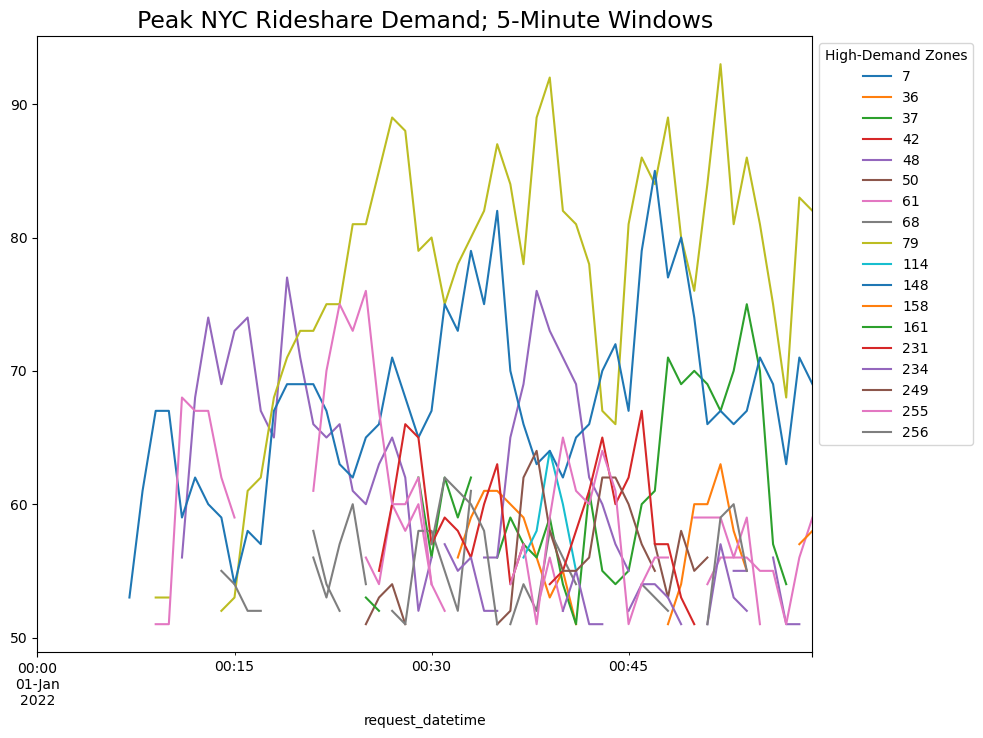

In [47]:
# one way to clarify the plot is to remove any columns with values below threshold
# let's say we want to identify zones with more than 50 requests per 5-minute window
signal = windows[(windows > 50)].dropna(axis=1, how="all")
signal.plot(figsize=(10,8))
plt.legend(bbox_to_anchor=(1.0,1.0), title="High-Demand Zones")
plt.title("Peak NYC Rideshare Demand; 5-Minute Windows", size=17)
plt.show()

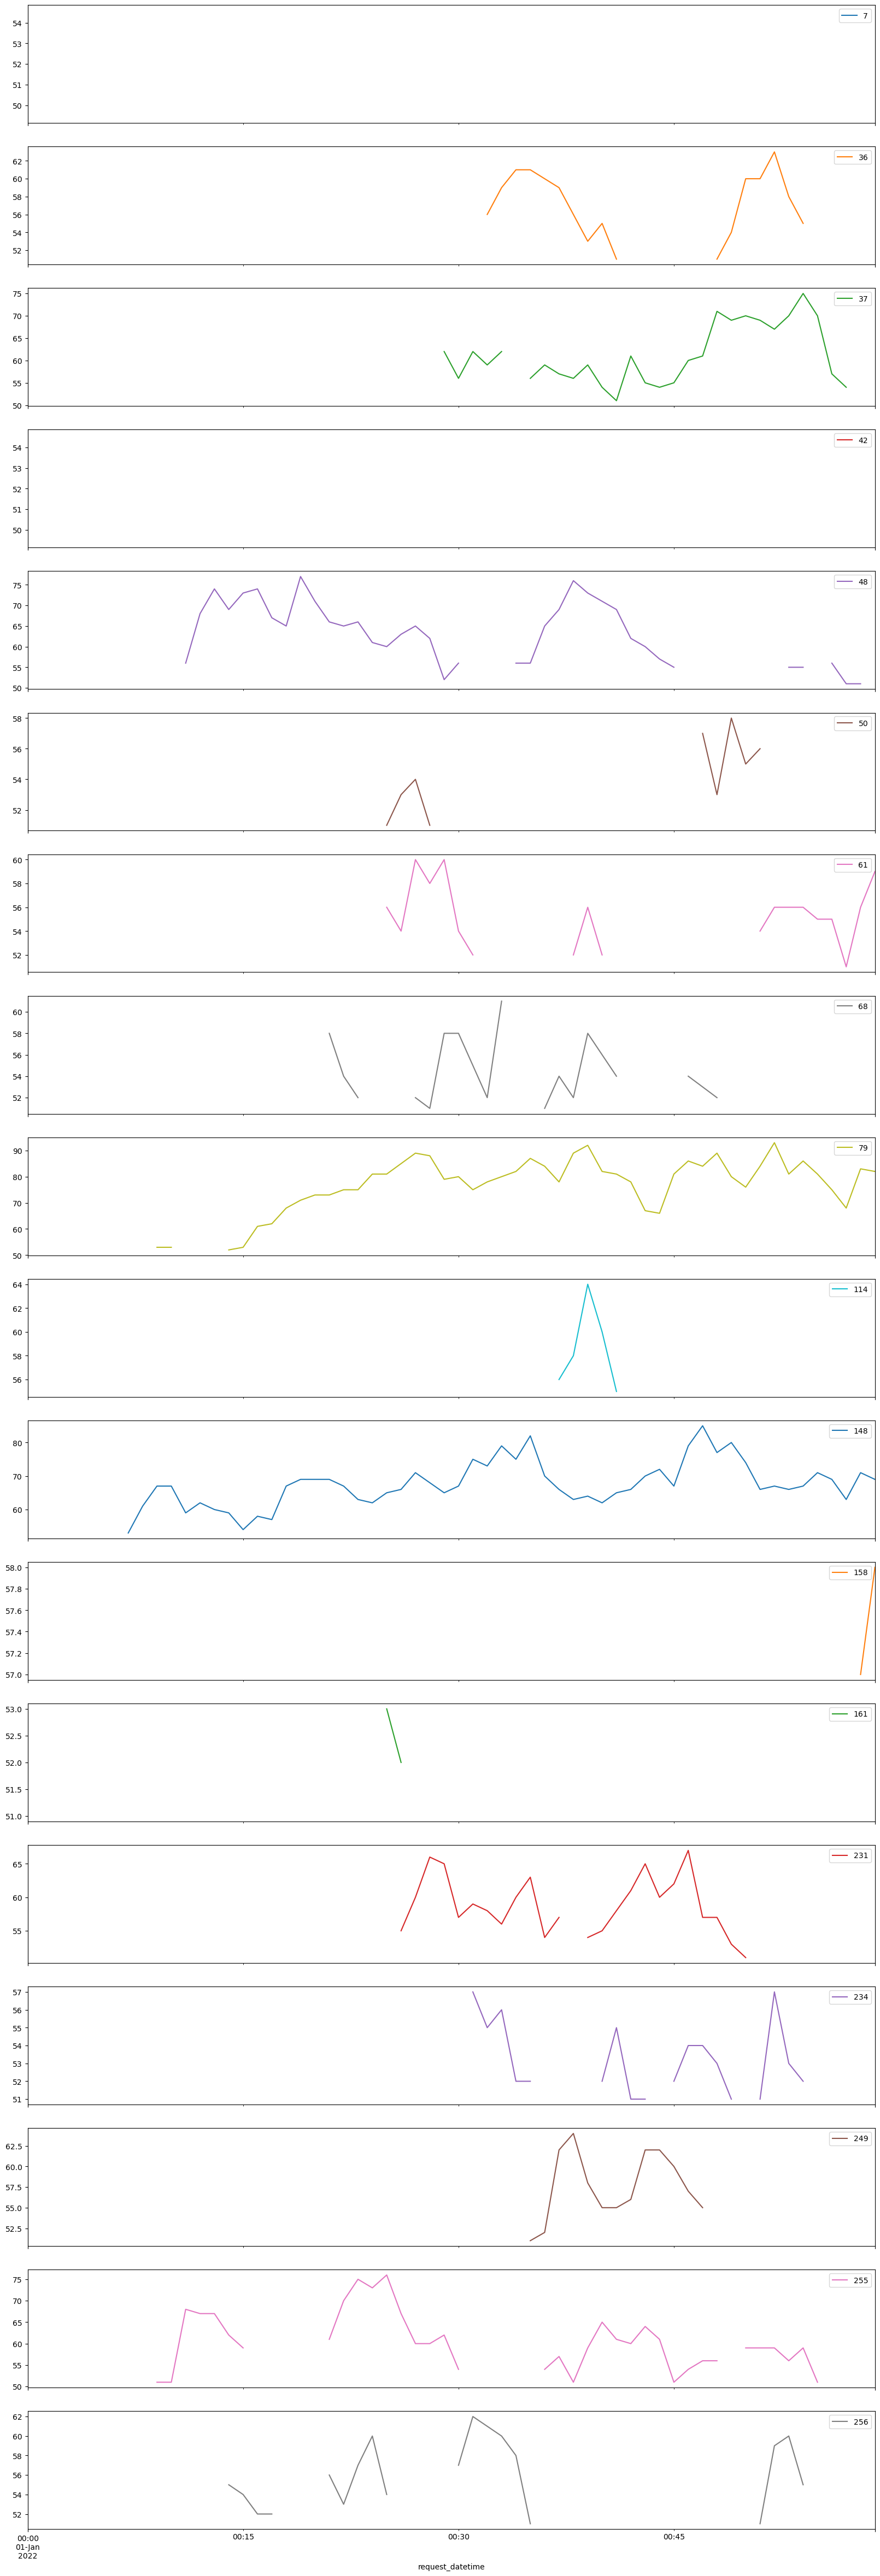

In [74]:
# or we can do subplots for each column
signal.plot(subplots=True, figsize=(20,60));